<a href="https://colab.research.google.com/github/Atharva-Gaykar/Deep_Learning/blob/main/notebooks/text_data/TEXT_CLASSIFICATION_USING_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🧠 Through this project: Human vs AI Essay Classification using BERT
I worked on a binary text classification task where the goal was to distinguish between human-written and AI-generated essays.

Used a pre-trained BERT model (e.g., bert-base-uncased) and fine-tuned it on a labeled dataset of essays.

Learned how transformer-based models like BERT can capture deep semantic and contextual meaning from text.

Applied tokenization using BERT's tokenizer to handle subword units, padding, and attention masks.

Preprocessed the text data by cleaning, lowercasing, and truncating/padding to a fixed sequence length.

Used binary cross-entropy loss with sigmoid activation in the output layer for the classification task.

Evaluated model performance using metrics like accuracy, precision, recall, and ROC-AUC.

Understood how to avoid overfitting through techniques like dropout, learning rate scheduling, and validation monitoring.

Realized the challenges in distinguishing AI vs human writing, especially when the writing quality is similar.

Gained hands-on experience with Hugging Face Transformers, PyTorch/TensorFlow, and transfer learning in NLP

CLS TOKEN IS USED FOR TEXT CLASSIFICATION

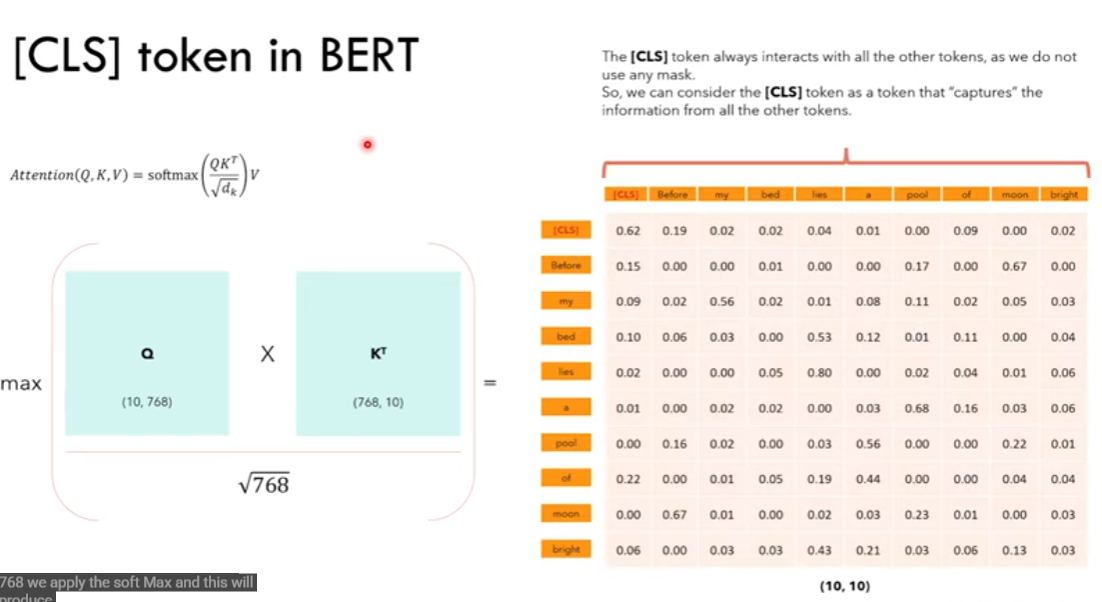

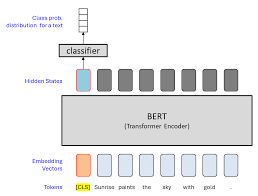

In [ ]:
ACTIVATION FUNCTION USED

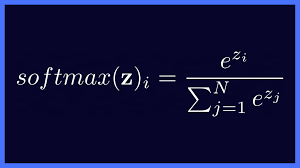

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shanegerami/ai-vs-human-text")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ai-vs-human-text


In [ ]:
import pandas as pd
import os

dataset_directory = "/kaggle/input/ai-vs-human-text"
csv_file_path = None
for root, _, files in os.walk(dataset_directory):
    for file in files:
        if file.endswith(".csv"):
            csv_file_path = os.path.join(root, file)
            break
    if csv_file_path:
        break

if csv_file_path:
    raw_dt = pd.read_csv(csv_file_path)
    print(f"Successfully loaded data from: {csv_file_path}")
else:
    print(f"No CSV file found in the directory: {dataset_directory}")

Successfully loaded data from: /kaggle/input/ai-vs-human-text/AI_Human.csv


In [ ]:
ai_essays = raw_dt[raw_dt['generated']==1]
human_essays = raw_dt[raw_dt['generated']==0]
print(ai_essays.shape, human_essays.shape)

(181438, 2) (305797, 2)


In [ ]:
work_dt = pd.concat([ai_essays.sample(n=3200, random_state=42), human_essays.sample(n=3200, random_state=42)])
work_dt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6400 entries, 279451 to 133629
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       6400 non-null   object 
 1   generated  6400 non-null   float64
dtypes: float64(1), object(1)
memory usage: 150.0+ KB


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [ ]:
X = work_dt['text']
y = work_dt['generated']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42,stratify=work_dt['generated'])

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42,stratify=y_temp)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 4480
Validation set size: 960
Test set size: 960


In [ ]:
y_train.value_counts()

,count
generated,
0.0,2240
1.0,2240


In [ ]:
from transformers import BertTokenizerFast, BertForSequenceClassification

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_encodings = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding='max_length',
    max_length=300
)

val_encodings = tokenizer(
    X_val.tolist(),
    truncation=True,
    padding='max_length',
    max_length=300
)

test_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding='max_length',
    max_length=300
)


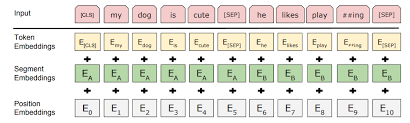

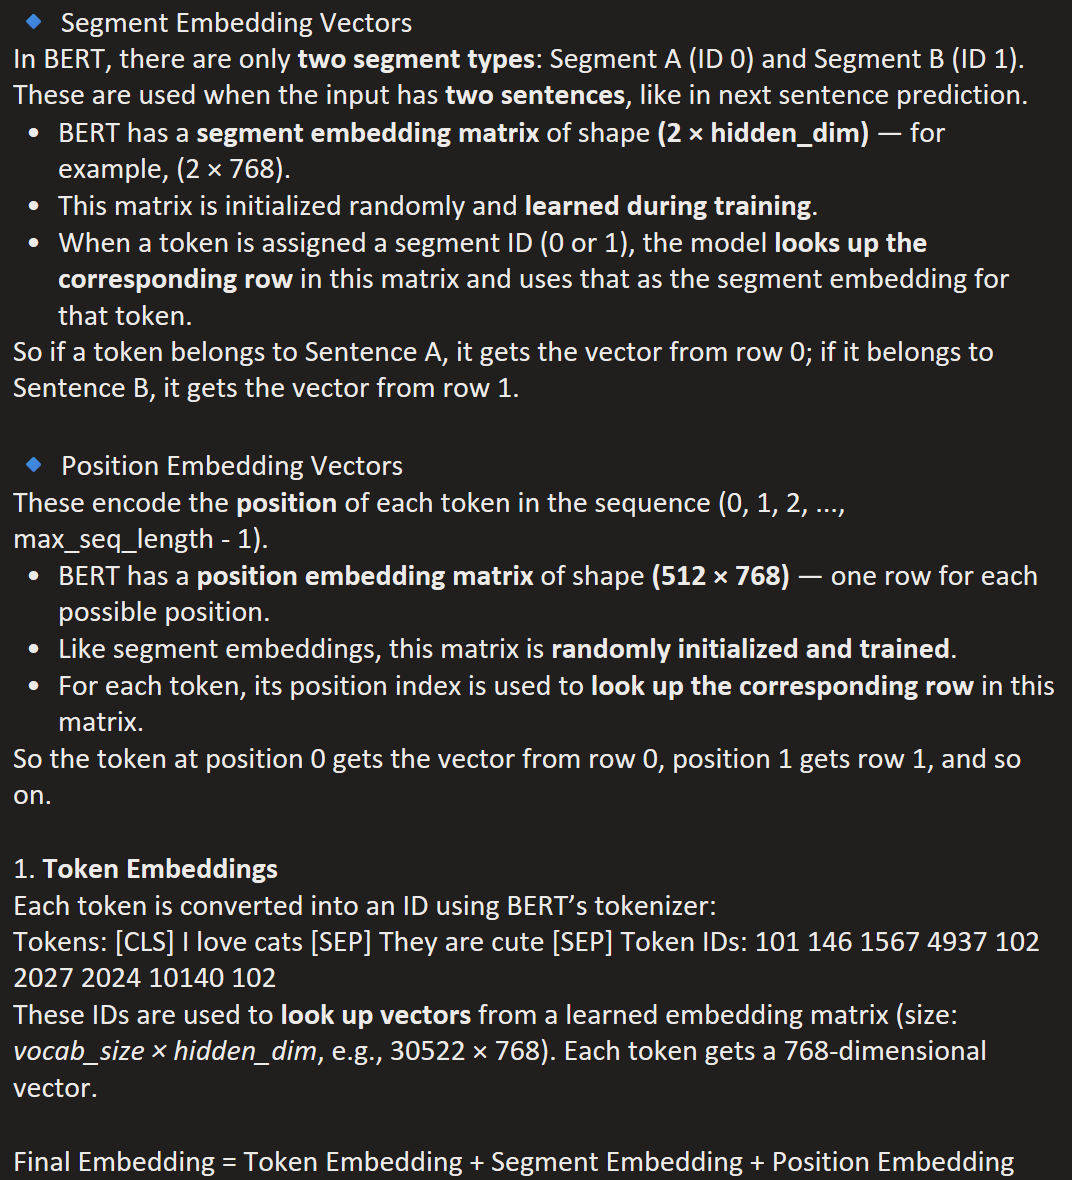

In [ ]:
import torch

class EssayDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.tolist()  # Make sure it's a list, not Series

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
train_dataset = EssayDataset(train_encodings, y_train)
val_dataset   = EssayDataset(val_encodings, y_val)
test_dataset  = EssayDataset(test_encodings, y_test)


🧠 BERT Pre-training: Key Concepts
BERT is pre-trained on large unlabeled corpora (like Wikipedia and BookCorpus) using two self-supervised learning tasks:

🔹 1. Masked Language Modeling (MLM)
Randomly masks 15% of the tokens in the input sequence.

The model must predict the original masked tokens using context from both directions.

Enables BERT to learn bidirectional contextual representations.

Masking Strategy:
80% of the time: replace token with [MASK].

10% of the time: replace token with a random token.

10% of the time: keep the token unchanged.

This variation ensures BERT does not become overly reliant on the [MASK] token during training.

🔹 2. Next Sentence Prediction (NSP)
BERT is given pairs of sentences: Sentence A and Sentence B.

The task is to predict if Sentence B logically follows Sentence A.

Training Data Split:
50% of the time: Sentence B is the actual next sentence → labeled "IsNext".

50% of the time: Sentence B is a random sentence from the corpus → labeled "NotNext".

This helps BERT understand sentence-level relationships, crucial for tasks like question answering, natural language inference, etc.

Post-Pre-training


Once pre-trained, the BERT model can be fine-tuned with minimal modifications for a wide variety of downstream tasks, including sentiment analysis, named entity recognition, question answering, and more. Fine-tuning is considerably less computationally expensive than pre-training and involves training the pre-trained model on a smaller, task-specific labeled dataset.
BERT's introduction marked a significant advancement in NLP, paving the way for further research and developments in pre-trained language models. Its approach has been influential, inspiring many subsequent models that continue to push the boundaries of language understanding.

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🛠️ Understanding the Trainer API (Hugging Face Transformers)
The Trainer API is a high-level training loop abstraction provided by Hugging Face's 🤗 transformers library.

Simplifies the process of training, evaluating, and predicting with transformer models (like BERT, RoBERTa, etc.).

Handles core functionalities such as:

Forward and backward pass

Gradient clipping

Optimizer and learning rate scheduling

Model saving and checkpointing

Logging and evaluation

Uses a TrainingArguments object to control training hyperparameters like:

learning_rate, num_train_epochs, per_device_train_batch_size, evaluation_strategy, etc.

Supports mixed-precision (FP16) training, multi-GPU, and TPU training out of the box.

Works seamlessly with datasets formatted using Hugging Face Datasets library.

Allows customization via:

compute_metrics — to define your own accuracy, precision, F1, etc.

callbacks — for early stopping or custom hooks.

Great for fine-tuning pre-trained models with minimal boilerplate code.

In [ ]:
from transformers import  Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
     report_to="none",
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)




In [ ]:


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

Step,Training Loss
10,0.769900
20,0.756400
30,0.701100
40,0.652400
50,0.555300
60,0.486500
70,0.434600
80,0.407400
90,0.318100
100,0.289700


TrainOutput(global_step=840, training_loss=0.1367774550049078, metrics={'train_runtime': 889.4393, 'train_samples_per_second': 15.111, 'train_steps_per_second': 0.944, 'total_flos': 2071999560960000.0, 'train_loss': 0.1367774550049078, 'epoch': 3.0})

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.08436616510152817, 'eval_runtime': 16.2797, 'eval_samples_per_second': 58.969, 'eval_steps_per_second': 0.921, 'epoch': 3.0}


In [ ]:
predictions = trainer.predict(test_dataset)

In [ ]:
from sklearn.metrics import classification_report

preds = predictions.predictions.argmax(-1)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       480
         1.0       0.97      1.00      0.98       480

    accuracy                           0.98       960
   macro avg       0.98      0.98      0.98       960
weighted avg       0.98      0.98      0.98       960



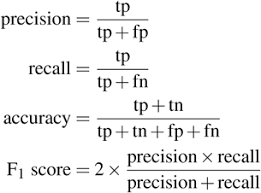